## Generate training data

In [1]:
import numpy as np
from cobra.io import load_model
import matplotlib.pyplot as plt
import FBA_data_generation
import plotting

In [2]:
model = load_model("textbook")
# model = load_model("iJO1366")
vman = "PFK"
file_path = f"data/fba_data_{vman}_aerobic.npz"

In [3]:
# anaerobic conditions
# upper bound glucose uptake: 10 mmol/g/h

medium = model.medium
medium["EX_o2_e"] = 0.0
model.medium = medium

file_path = f"data/fba_data_{vman}_anaerobic.npz"

model.medium

{'EX_co2_e': 1000.0,
 'EX_glc__D_e': 10.0,
 'EX_h_e': 1000.0,
 'EX_h2o_e': 1000.0,
 'EX_nh4_e': 1000.0,
 'EX_pi_e': 1000.0}

In [4]:
# generate new FBA data
X, Y, feasibility_dict = FBA_data_generation.generate_fba_data(model, vman, file_path)

upper bound: 0.0. lower bound: 1000.0


/Users/Pineapplethefruitdude/Documents/Uni/Uni Köln/Master Project/Code/vincent_code/.venv/lib/python3.13/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


In [6]:
print(len(X))

26


In [5]:
# load existing FBA data
data = np.load(file_path, allow_pickle=True)

X = data["X"]
Y = data["Y"]
feasibility_dict = data["feasibility_dict"].item()  # unpack from object dtype

In [6]:
# view infeasible regions
regions = FBA_data_generation.list_infeasible_regions(feasibility_dict)

Infeasible regions for PFK:
  [0.00, 3.00]
  [30.03, 1000.00]


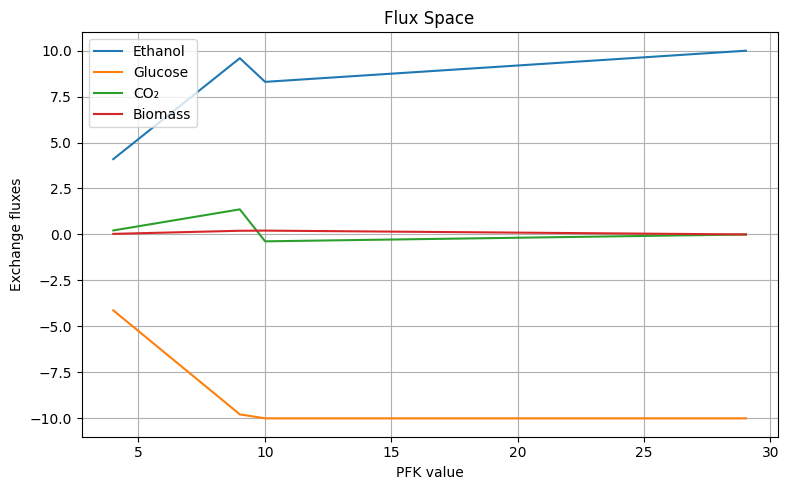

In [7]:
plotting.plot_flux_space(
    X, Y,
    vman_id=vman,
    output_labels=["Ethanol", "Glucose", "CO₂", "Biomass"]
)

## Train Surrogate in PyTorch

In [8]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import surrogateNN

In [9]:
x_scaler, y_scaler, X_train, Y_train, X_val, Y_val, X_test, Y_test = surrogateNN.ML_data_prep(X, Y)
neurons = 4

model_nn = surrogateNN.SurrogateNN(
    input_dim=X_train.shape[1],
    output_dim=Y_train.shape[1],
    hidden_dim=neurons
)

loss_fn=nn.MSELoss()

In [22]:
print(Y.shape)


(26, 4)


In [20]:
model_nn, train_losses, val_losses = surrogateNN.train_model(
    model_nn, X_train, Y_train, X_val, Y_val,
    loss_fn=loss_fn, epochs=5000, patience=50
)

Epoch 000 | Train Loss: 1.0081 | Val Loss: 0.9684
Early stopping triggered at epoch 050 | Train Loss: 0.9075 | Val Loss: 0.9757


In [11]:
from pathlib import Path
import torch

# Define base directory for models
MODEL_DIR = Path("trained_models")
MODEL_DIR.mkdir(exist_ok=True)  # create folder if it doesn't exist

# Construct consistent filename
model_filename = f"{vman}_trained_model_input-{X_train.shape[1]}_output-{Y_train.shape[1]}_hidden-{neurons}.pt"
model_path = MODEL_DIR / model_filename

# --- Save model ---
torch.save(model_nn.state_dict(), model_path)

In [12]:
# Rebuild the model architecture (must match original)
model_nn = surrogateNN.SurrogateNN(input_dim=1, hidden_dim=4, output_dim=4)

# Load weights
model_nn.load_state_dict(torch.load(model_path, map_location="cpu"))
model_nn.eval()  # important for inference


SurrogateNN(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
  )
)

In [13]:
# save full model
#torch.save({
#    "model_state": model_nn.state_dict(),
#    "optimizer_state": optimizer.state_dict(),
#    "epoch": epoch,
#    "train_losses": train_losses,
#}, "checkpoint.pth")

#checkpoint = torch.load("checkpoint.pth")
#model_nn.load_state_dict(checkpoint["model_state"])
#optimizer.load_state_dict(checkpoint["optimizer_state"])

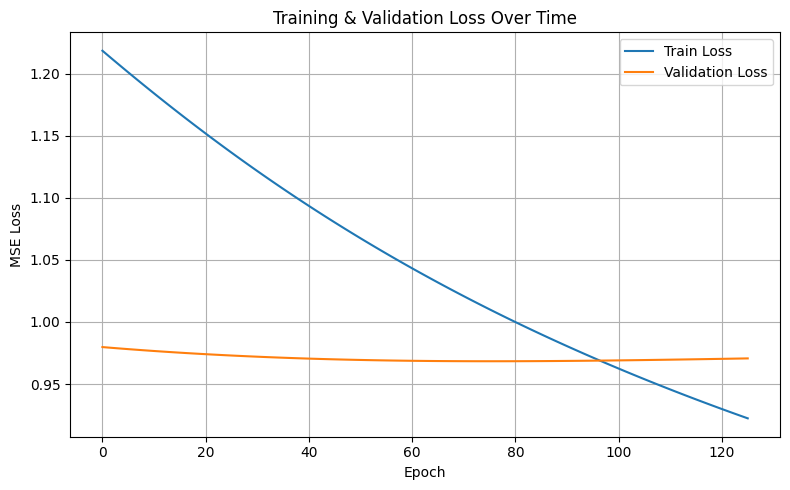

In [14]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training & Validation Loss Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
model_nn.eval()
with torch.no_grad():
    pred_test = model_nn(X_test)
    loss_test = loss_fn(pred_test, Y_test)

print(f"Final Test MSE: {loss_test.item():.4f}")


Final Test MSE: 1.3361


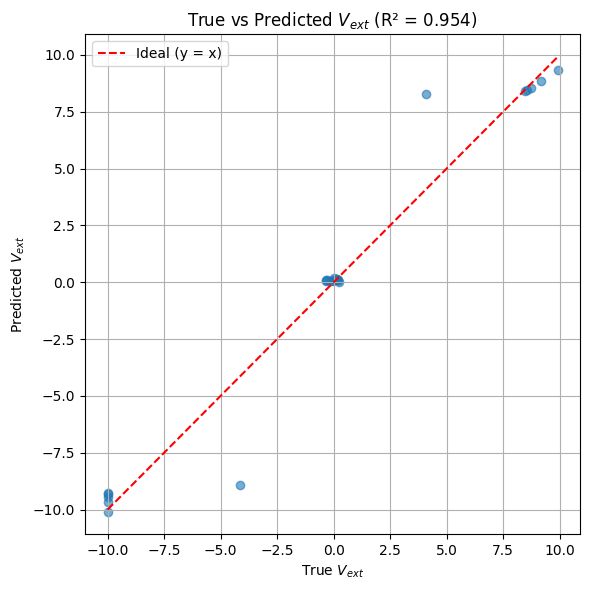

In [16]:
Y_test_np = Y_test.numpy()
pred_test_np = pred_test.numpy()

# Undo scaling
Y_test_true = y_scaler.inverse_transform(Y_test_np)
pred_test_true = y_scaler.inverse_transform(pred_test_np)

# Flatten to plot across all outputs
Y_true_flat = Y_test_true.flatten()
Y_pred_flat = pred_test_true.flatten()

# R² score
r2 = r2_score(Y_true_flat, Y_pred_flat)

# Scatterplot
plt.figure(figsize=(6, 6))
plt.scatter(Y_true_flat, Y_pred_flat, alpha=0.6)
plt.plot([Y_true_flat.min(), Y_true_flat.max()],
         [Y_true_flat.min(), Y_true_flat.max()],
         'r--', label="Ideal (y = x)")
plt.xlabel("True $V_{ext}$")
plt.ylabel("Predicted $V_{ext}$")
plt.title(f"True vs Predicted $V_{{ext}}$ (R² = {r2:.3f})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Build the Hybrid Model

In [17]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import hybrid_model

2.3.4


In [18]:
def vman_func(t):
    return 1.0  # constant PFK flux
    # return 5.0 + 2.0 * np.sin(0.5 * t)  # sinusoidal control

In [19]:
# initial state: [glucose, ethanol, biomass]
z0 = [10.0, 0.0, 0.01]
tspan = (0, 6)
t_eval = np.linspace(tspan[0], tspan[1], 200)

sol = solve_ivp(
    fun=lambda t, z: hybrid_model.hybrid_ode(t, z, vman_func, model_nn, x_scaler, y_scaler),
    t_span=tspan,
    y0=z0,
    t_eval=t_eval,
    method='RK45'
)

TypeError: only integer scalar arrays can be converted to a scalar index

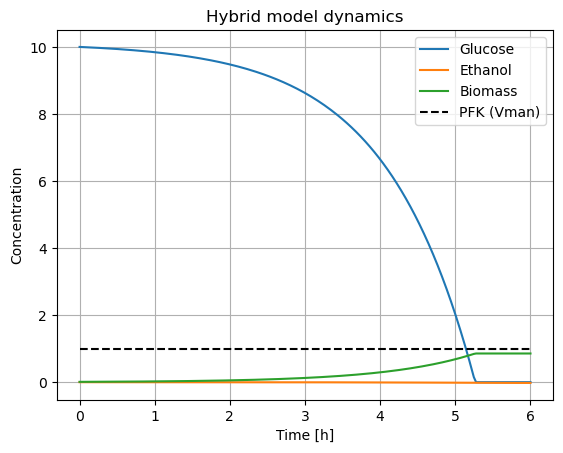

In [ ]:
plt.plot(sol.t, sol.y[0], label='Glucose')
plt.plot(sol.t, sol.y[1], label='Ethanol')
plt.plot(sol.t, sol.y[2], label='Biomass')
vman_values = [vman_func(t) for t in sol.t]
plt.plot(sol.t, vman_values, label='PFK (Vman)', linestyle='--', color='black')
plt.xlabel("Time [h]")
plt.ylabel("Concentration")
plt.title("Hybrid model dynamics")
plt.legend()
plt.grid(True)
plt.show()

## Vman Optimization - doesn't work yet

In [ ]:
from scipy.optimize import minimize

def piecewise_constant_vman(t, control_values, time_points):
    """Return control value at time t from piecewise-constant vman profile."""
    for i, t0 in enumerate(time_points[:-1]):
        if t0 <= t < time_points[i + 1]:
            return control_values[i]
    return control_values[-1]  # handle t == end

def simulate_biomass(control_values, time_points, z0, model_nn, x_scaler, y_scaler):
    """
    Simulate hybrid model and return negative biomass at final time
    (minimize this to maximize biomass).
    """
    vman_func = lambda t: piecewise_constant_vman(t, control_values, time_points)

    sol = solve_ivp(
        fun=lambda t, z: hybrid_model.hybrid_ode(t, z, vman_func, model_nn, x_scaler, y_scaler),
        t_span=(time_points[0], time_points[-1]),
        y0=z0,
        t_eval=time_points,
        method="RK45"
    )

    biomass = sol.y[2, -1]  # biomass is the 3rd species
    return -biomass  # negate to maximize


In [ ]:
# Setup time and initial conditions
N = 6  # number of vman segments
T = 6  # total simulation time [hours]
z0 = [10.0, 0.0, 0.01]  # initial glucose, ethanol, biomass

time_points = np.linspace(0, T, N + 1)

# Get bounds for vman
model = load_model("textbook")
rxn = model.reactions.get_by_id(vman)
vmin, vmax = rxn.lower_bound, rxn.upper_bound

# Initial guess: mid-range
initial_guess = np.full(N, (vmin + vmax) / 2)

# Bounds for optimization
bounds = [(vmin, vmax)] * N

# Optimize
result = minimize(
    simulate_biomass,
    x0=initial_guess,
    args=(time_points, z0, model_nn, x_scaler, y_scaler),
    bounds=bounds,
    method="L-BFGS-B",
    options={"disp": True, "maxiter": 200}
)

opt_vman = result.x

/tmp/ipykernel_177692/3330325563.py:20: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  result = minimize(


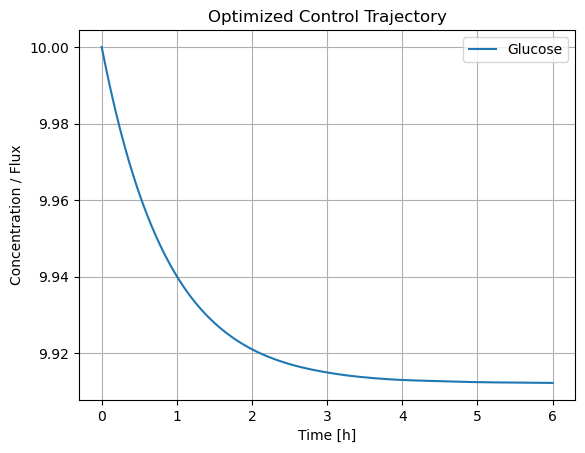

In [ ]:
# Simulate again with optimal vman trajectory
opt_vman_func = lambda t: piecewise_constant_vman(t, opt_vman, time_points)

sol = solve_ivp(
    fun=lambda t, z: hybrid_model.hybrid_ode(t, z, opt_vman_func, model_nn, x_scaler, y_scaler),
    t_span=(0, T),
    y0=z0,
    t_eval=np.linspace(0, T, 300)
)

plt.plot(sol.t, sol.y[0], label='Glucose')
#plt.plot(sol.t, sol.y[1], label='Ethanol')
#plt.plot(sol.t, sol.y[2], label='Biomass')
# plt.plot(sol.t, [opt_vman_func(t) for t in sol.t], '--', label='Optimized vman')
plt.xlabel("Time [h]")
plt.ylabel("Concentration / Flux")
plt.title("Optimized Control Trajectory")
plt.grid(True)
plt.legend()
plt.show()
